# Projet 6 : Classification automatique des biens de consommation

## Mission 2 - Réaliser une classification supervisée d'images

### Problématique :

* Après mon travail sur la faisabilité d'un moteur de classification, je continue mon travail au sein de "Place du marché". J'ai déjà partagé le travail effectué lors de votre mission précédente avec Lead Data Scientist, Linda. Elle m'invite désormais à aller plus loin dans l'analyse d'images. 

**Objectifs :**
- Réaliser une classification supervisée à partir des images.
    - Mettre en place une data augmentation afin d'optimiser le modèle.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,adjusted_rand_score,confusion_matrix,classification_report
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.models import Model,Sequential,clone_model
from tensorflow.keras.layers import (GlobalAveragePooling2D,Flatten,Dense,Dropout,Activation,Rescaling, 
                                     RandomFlip,RandomRotation,RandomZoom)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from plot_keras_history import show_history, plot_history

# I. Prétraitement des données images

In [2]:
# Directory to get to the images
path = "../P6_classification_auto_bien_consommation/Images/"

# List of all the images 
list_photos = [file for file in listdir(path)]
print(f"Nous avons {len(list_photos)} images.")

Nous avons 1050 images.


In [3]:
# Import  data
image_data = pd.read_csv("flipkart_com-ecommerce_sample_1050.csv") 

# Splitting sub-categories into new columns
classes = image_data["product_category_tree"].str.split(" >> ", expand=True)

# Separate the levels of categories
image_data["labels"] = classes[0] 

# Cleaning the [" in our labels
image_data = image_data.replace('\\["', '', regex=True)

# Encoding the categories
label_encoder = LabelEncoder()
image_data["labels_encoded"] = label_encoder.fit_transform(np.array(image_data["labels"]))

# Keeping images and categories only
image_data = image_data[["image","labels","labels_encoded"]]

# getting the images and all the path 
image_data["image_directory"] = image_data.image.apply(lambda x: path+str(x))
image_data.sample(10)

,image,labels,labels_encoded,image_directory
675,7f6678a6217c831b716feca796f689fd.jpg,Baby Care,0,../P6_classification_auto_bien_consommation/Im...
146,63bc43c0000e71eb11bfafd2f46214a4.jpg,Kitchen & Dining,5,../P6_classification_auto_bien_consommation/Im...
420,6c3768639e82ceaeab681e083b897672.jpg,Computers,2,../P6_classification_auto_bien_consommation/Im...
192,b4ccd4c315d99edd7c00d015b714485a.jpg,Kitchen & Dining,5,../P6_classification_auto_bien_consommation/Im...
676,ce9cb60201f1cdc33e4b58d3583c7a5c.jpg,Home Furnishing,4,../P6_classification_auto_bien_consommation/Im...
168,ea16e13a7cf16d8665d1bc44738dfa88.jpg,Kitchen & Dining,5,../P6_classification_auto_bien_consommation/Im...
13,189fa66a5fa6f08d2802a62ecf0be298.jpg,Watches,6,../P6_classification_auto_bien_consommation/Im...
58,3c4604dba348a99a2dfbbc2cd3928101.jpg,Beauty and Personal Care,1,../P6_classification_auto_bien_consommation/Im...
781,9924fba9b2a738e5a141995952e73104.jpg,Watches,6,../P6_classification_auto_bien_consommation/Im...
384,67119571e4b46deb266236d8e7fad65d.jpg,Beauty and Personal Care,1,../P6_classification_auto_bien_consommation/Im...


In [4]:
# Train test split 
image_data_train,image_data_test,_,_ = train_test_split(image_data,
             image_data["labels"],stratify=image_data["labels"],test_size=0.2,random_state=42)

print("Train data shape :",image_data_train.shape)
print()
print("Test data shape :",image_data_test.shape)

Train data shape : (840, 4)

Test data shape : (210, 4)


In [5]:
# Preparing the images

def image_preparation(data) :
    prepared_images = []
    for image_num in range(len(data["image_directory"])) :
        # load an image from dataset
        image = (load_img(
            data["image_directory"].iloc[image_num],
            target_size=(224, 224)))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # reshape data for the model
        image = image.reshape((image.shape[0], image.shape[1], image.shape[2]))
        # prepare the image for the VGG16 model
        image = preprocess_input(image)
        # Add the image to the list of prepared images for the VGG16 model
        prepared_images.append(image)
        # Convert list of prepared images to array
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np

temps1 = time.time()
images_train = image_preparation(image_data_train)
images_test = image_preparation(image_data_test)
print("Taille du jeu de données d'entraînement :",images_train.shape)
print()
print("Taille du jeu de données de test :",images_test.shape)
print()
duration1=time.time()-temps1
print("temps d'entraînement du modèle : ", "%15.2f" % duration1, "secondes")

Taille du jeu de données d'entraînement : (840, 224, 224, 3)

Taille du jeu de données de test : (210, 224, 224, 3)

temps d'entraînement du modèle :           386.44 secondes


In [6]:
X = images_train
X_test = images_test
# Encoding targets
y = to_categorical(image_data_train["labels_encoded"])
y_test = to_categorical(image_data_test["labels_encoded"])

y

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [7]:
# Train validation split 
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
# Shapes : 
print(f"Dimensions of X_train : {X_train.shape}")
print(f"Dimensions of y_train : {y_train.shape}")
print(f"Dimensions of X_val : {X_val.shape}")
print(f"Dimensions of y_val : {y_val.shape}")
print(f"Dimensions of X_test : {X_test.shape}")
print(f"Dimensions of y_test : {X_test.shape}")

Dimensions of X_train : (630, 224, 224, 3)
Dimensions of y_train : (630, 7)
Dimensions of X_val : (210, 224, 224, 3)
Dimensions of y_val : (210, 7)
Dimensions of X_test : (210, 224, 224, 3)
Dimensions of y_test : (210, 224, 224, 3)


# II. Classification supervisée d'images

Pour la classification supervisée à partir des images, nous présentons deux approches différentes :
* Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée
* Une approche par DataSet en utilisant TensorFlow tf.image, avec data augmentation intégrée au modèle 

# 1. Approche simple par préparation initiale des images et transfert learning avec VGG16

In [17]:
def create_model() :
    # Getting pre-trained model
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    # Freeze VGG16 layers
    for layer in model0.layers:
        layer.trainable = False
    
    # Get the output of the network
    x = model0.output
    # Add other layers to get a completed model
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation="softmax")(x)

    # Instanciate final model
    model = Model(inputs=model0.input, outputs=predictions)
    # Model compilation 
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
    # Model summary
    print(model.summary())
    
    return model
    

In [18]:
# Create the model
model1 = create_model()

# Save the model
model1.save('../P6_classification_auto_bien_consommation/location.keras')     
model1_save_path = '../P6_classification_auto_bien_consommation/location.keras'
# Creation of the callbacks
checkpoint = ModelCheckpoint(model1_save_path,monitor='val_loss',verbose=1,save_best_only=True,mode='min')
# Early stopping 
es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)
callbacks_list = [checkpoint, es]

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,3

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [19]:
temps1 = time.time()
# Train the model on the training data
history1 = model1.fit(X_train, y_train, epochs=10, batch_size=64, 
                       callbacks=callbacks_list,validation_data=(X_val, y_val), verbose=1)

duration1=time.time()-temps1
print("temps d'entraînement du modèle l : ", "%15.2f" % duration1, "secondes")

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.3300 - loss: 8.3957 
Epoch 1: val_loss improved from inf to 1.29970, saving model to ../P6_classification_auto_bien_consommation/location.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 134s 14s/step - accuracy: 0.3398 - loss: 8.1497 - val_accuracy: 0.7619 - val_loss: 1.2997
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.7023 - loss: 2.2285 
Epoch 2: val_loss improved from 1.29970 to 1.11343, saving model to ../P6_classification_auto_bien_consommation/location.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 151s 15s/step - accuracy: 0.7009 - loss: 2.2292 - val_accuracy: 0.7857 - val_loss: 1.1134
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.6964 - loss: 1.6356 
Epoch 3: val_loss improved from 1.11343 to 0.98189, saving model to ../P6_classification_auto_bien_consommation/location.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 140s 14s/step - accuracy: 0.6992 - loss: 1.6314 - val_accuracy: 0.7905 - val_loss: 0.9819
Epoch 4/10
10/10 

In [20]:
# Score of the last epoch
loss, accuracy = model1.evaluate(X_train, y_train,verbose=True)
print("Training Accuracy of the last epoch : {:.4f}".format(accuracy))
print("Training loss of the last epoch : {:.4f}".format(loss))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy of the last epoch :  {:.4f}".format(accuracy))
print("Validation loss of the last epoch :  {:.4f}".format(loss))

20/20 ━━━━━━━━━━━━━━━━━━━━ 98s 5s/step - accuracy: 0.9953 - loss: 0.0129
Training Accuracy of the last epoch : 0.9937
Training loss of the last epoch : 0.0179

7/7 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step - accuracy: 0.8378 - loss: 0.7752
Validation Accuracy of the last epoch :  0.8333
Validation loss of the last epoch :  0.7362


In [21]:
# Optimal validation and test scores 

model1.load_weights(model1_save_path)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Optimal validation Accuracy :  {:.4f}".format(accuracy))
print("Optimal validation loss :  {:.4f}".format(loss))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Optimal test Accuracy :  {:.4f}".format(accuracy))
print("Optimal test loss :  {:.4f}".format(loss))

Optimal validation Accuracy :  0.8333
Optimal validation loss :  0.7250
Optimal test Accuracy :  0.7857
Optimal test loss :  1.1582


### Evolution de la performance du modèle

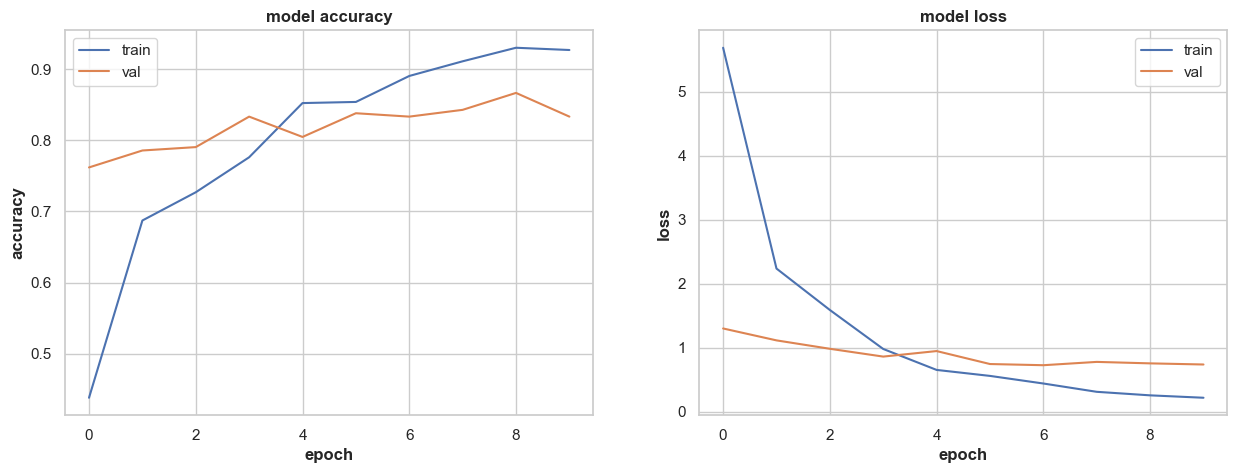

In [22]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.set(style="whitegrid")

axes[1].plot(history1.history['loss'])
axes[1].plot(history1.history['val_loss'])
axes[1].set_title('model loss',fontweight="bold")
axes[1].set_ylabel('loss',fontweight="bold")
axes[1].set_xlabel('epoch',fontweight="bold")
axes[1].legend(['train', 'val'], loc='best')

axes[0].plot(history1.history['accuracy'])
axes[0].plot(history1.history['val_accuracy'])
axes[0].set_title('model accuracy',fontweight="bold")
axes[0].set_ylabel('accuracy',fontweight="bold")
axes[0].set_xlabel('epoch',fontweight="bold")
axes[0].legend(['train', 'val'], loc='best')

plt.show()

In [23]:
# pip install plot_keras_history 

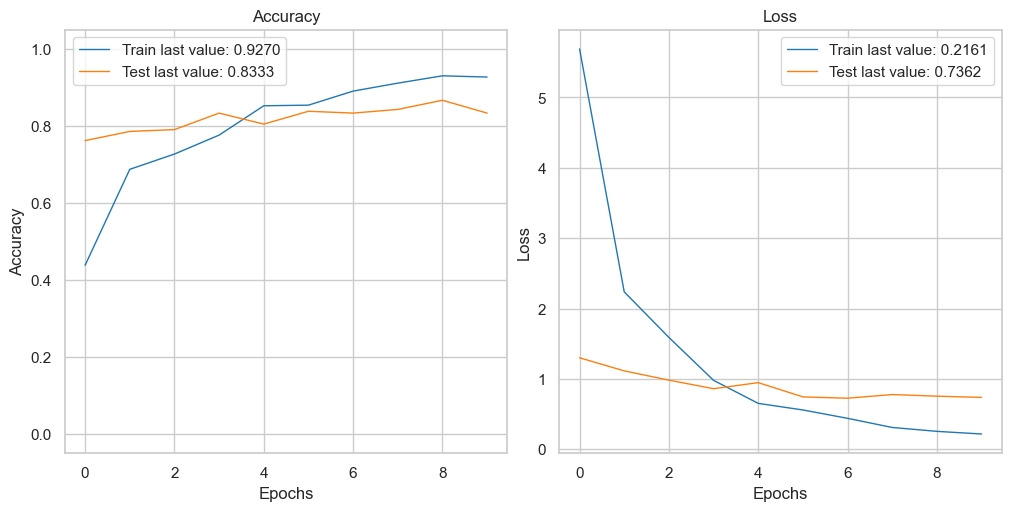

In [24]:

# Show the model performance evolution 
show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

### Performance du modèle sur les données de test

In [25]:
# Test data
y_test1 = np.argmax(y_test, axis=1)
y_pred1 = np.argmax(model1.predict(X_test), axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step


              precision    recall  f1-score   support

           0       0.67      0.73      0.70        30
           1       0.88      0.73      0.80        30
           2       0.88      0.70      0.78        30
           3       0.63      0.80      0.71        30
           4       0.79      0.77      0.78        30
           5       0.87      0.90      0.89        30
           6       0.87      0.87      0.87        30

    accuracy                           0.79       210
   macro avg       0.80      0.79      0.79       210
weighted avg       0.80      0.79      0.79       210




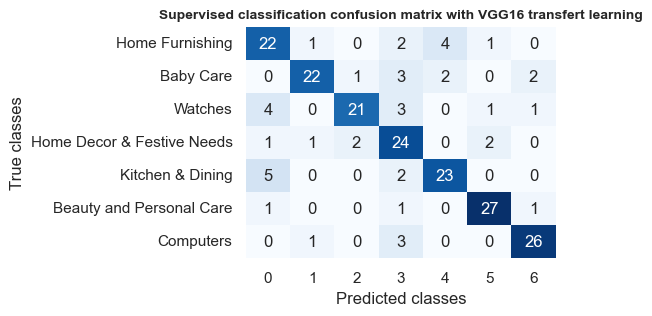

In [27]:
# Confusion matrix and classification report on the test data
conf_mat = confusion_matrix(y_test1,y_pred1)
# Classification report
print(classification_report(y_test1,y_pred1))
print()
list_labels = image_data.labels.unique().tolist()
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (4,3))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="Blues",cbar=False)
plt.xlabel("Predicted classes")
plt.ylabel("True classes")
plt.title("Supervised classification confusion matrix with VGG16 transfert learning",fontsize=10,fontweight="bold")
plt.show()

- La classification supervisée que l'on a éffectué affecte plutôt bien les produits à leurs classes initiales, à quelques erreurs de classification près.

# 2. Approche Tranfert learning VGG16 avec data augmentation intégrée au modèle

In [14]:
# Tranfert learning with VVG16 ang data augmentation
def creat_model2() :
    
    # Data augmentation pipeline 
    data_augmentation = Sequential([
        
        RandomFlip("horizontal", input_shape=(224, 224, 3)), #  randomly flips the input image horizontally                                                                           
        RandomRotation(0.1),    # randomly rotates the input by an angle of 0.1 radians
        RandomZoom(0.1)        # randomly zoom the image
      ])
    
    # Getting the VGG16 pre-trained model 
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    # Layer non-trainable = keep the weights of the pre-trained model
    for layer in model_base.layers:
        layer.trainable = False

    # Final model
    model = Sequential([
                data_augmentation,
                Rescaling(1./225),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')
                ])

    # configure the model for training
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
    # Model summary
    print(model.summary())
    
    return model

In [15]:
# Instanciate model
model2 = creat_model2()

# Save the model
model2.save('../P6_classification_auto_bien_consommation/location1.keras')     
model2_save_path = '../P6_classification_auto_bien_consommation/location1.keras'
# Callbacks
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [16]:
temps1 = time.time()
# Train the model on the training data
# batch_size=32,64,128
history2 = model2.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=64, epochs=10, callbacks=callbacks_list, verbose=1)

print()
duration1=time.time()-temps1
print("temps d'entraînement du modèle : ", "%15.2f" % duration1, "secondes")

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.1660 - loss: 2.0419
Epoch 1: val_loss improved from inf to 1.59008, saving model to ../P6_classification_auto_bien_consommation/location1.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 128s 14s/step - accuracy: 0.1710 - loss: 2.0336 - val_accuracy: 0.5952 - val_loss: 1.5901
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.3231 - loss: 1.7193 
Epoch 2: val_loss improved from 1.59008 to 1.33444, saving model to ../P6_classification_auto_bien_consommation/location1.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 145s 14s/step - accuracy: 0.3271 - loss: 1.7119 - val_accuracy: 0.6905 - val_loss: 1.3344
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.5301 - loss: 1.4124 
Epoch 3: val_loss improved from 1.33444 to 1.16606, saving model to ../P6_classification_auto_bien_consommation/location1.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 135s 14s/step - accuracy: 0.5321 - loss: 1.4084 - val_accuracy: 0.6952 - val_loss: 1.1661
Epoch 4/10
10/1

In [17]:
# Score of the last epoch
loss, accuracy = model2.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy of the last epoch : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy of the last epoch :  {:.4f}".format(accuracy))

20/20 ━━━━━━━━━━━━━━━━━━━━ 98s 5s/step - accuracy: 0.8078 - loss: 0.6607
Training Accuracy of the last epoch : 0.7984

7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - accuracy: 0.8015 - loss: 0.7981
Validation Accuracy of the last epoch :  0.7762


In [20]:
# Optimal validation and test scores

model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(X_val, y_val, verbose=False)
print("Optimal validation Accuracy :  {:.4f}".format(accuracy))
print("Optimal validation loss :  {:.4f}".format(loss))
print()
loss, accuracy = model2.evaluate(X_test, y_test, verbose=False)
print("Optimal test Accuracy :  {:.4f}".format(accuracy))
print("Optimal test loss :  {:.4f}".format(loss))

Optimal validation Accuracy :  0.7762
Optimal validation loss :  0.7867

Optimal test Accuracy :  0.7095
Optimal test loss :  0.8848


### Evolution de la performance du modèle

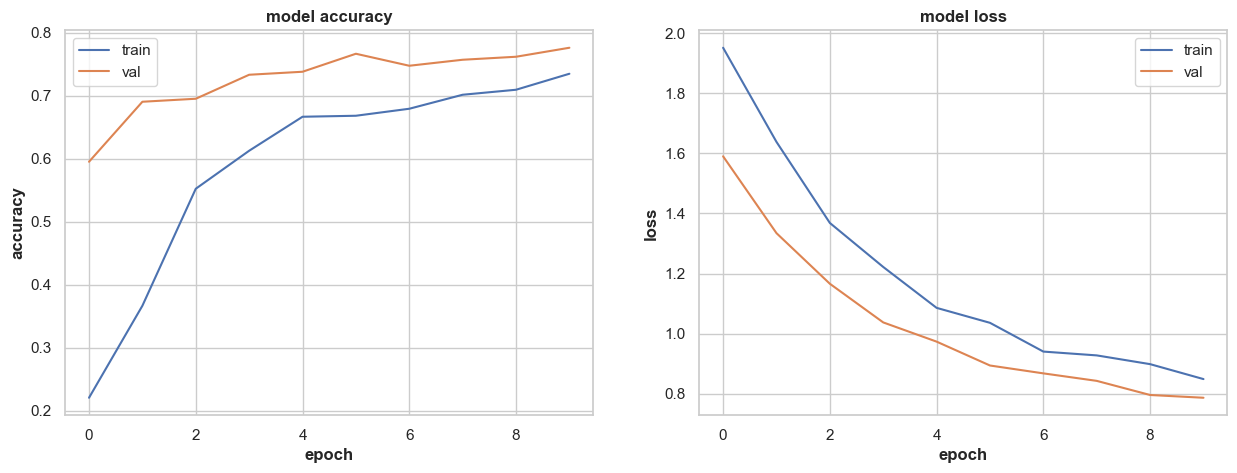

In [21]:
# Show the model performance evolution 
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.set(style="whitegrid")

axes[1].plot(history2.history['loss'])
axes[1].plot(history2.history['val_loss'])
axes[1].set_title('model loss',fontweight="bold")
axes[1].set_ylabel('loss',fontweight="bold")
axes[1].set_xlabel('epoch',fontweight="bold")
axes[1].legend(['train', 'val'], loc='best')

axes[0].plot(history2.history['accuracy'])
axes[0].plot(history2.history['val_accuracy'])
axes[0].set_title('model accuracy',fontweight="bold")
axes[0].set_ylabel('accuracy',fontweight="bold")
axes[0].set_xlabel('epoch',fontweight="bold")
axes[0].legend(['train', 'val'], loc='best')

plt.show()

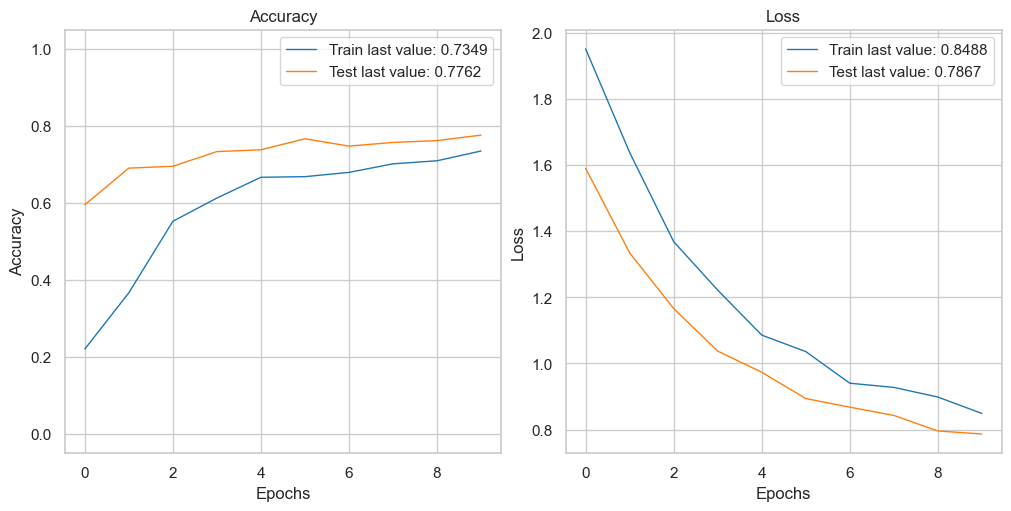

In [22]:
# Show the model performance evolution 
show_history(history2)
plot_history(history2, path="standard.png")
plt.close()

### Performance du modèle sur les données de test

In [23]:
# Test dataµ
y_test2 = np.argmax(y_test, axis=1)
y_pred2 = np.argmax(model2.predict(X_test), axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step


              precision    recall  f1-score   support

           0       0.62      0.70      0.66        30
           1       0.84      0.70      0.76        30
           2       0.62      0.67      0.65        30
           3       0.67      0.67      0.67        30
           4       0.62      0.43      0.51        30
           5       0.75      0.90      0.82        30
           6       0.84      0.90      0.87        30

    accuracy                           0.71       210
   macro avg       0.71      0.71      0.70       210
weighted avg       0.71      0.71      0.70       210




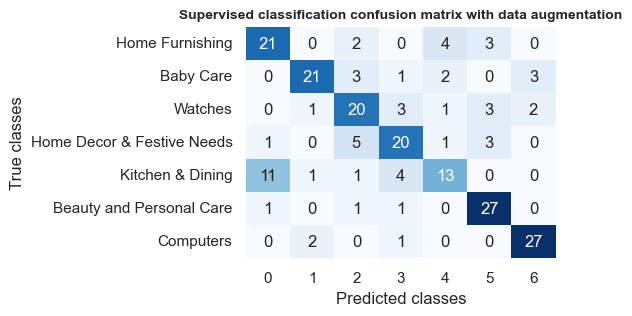

In [24]:
# Confusion matrix and classification report on the test data
conf_mat_augment = confusion_matrix(y_test2,y_pred2)

print(classification_report(y_test2,y_pred2))
print()
list_labels = image_data.labels.unique().tolist()
cm_augment = pd.DataFrame(conf_mat_augment, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (4,3))
sns.heatmap(cm_augment,annot=True,fmt="d",cmap="Blues",cbar=False)
plt.xlabel("Predicted classes")
plt.ylabel("True classes")
plt.title("Supervised classification confusion matrix with data augmentation",fontsize=10,fontweight="bold")
plt.show()